In [147]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
import argparse
import sys
import os
import numpy as np
import glob
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

from CustomDatasets import MagnetDataset
from Unet_MaxProkop import UNet
from Trainer import Trainer
import functions


In [149]:
if os.path.exists("../../Stage_magnet"):
    magnetfolder = "../../Stage_magnet"
else:
    magnetfolder = "../Stage_magnet"
    
if not os.path.exists("../../MagnetDataset.npz"):
    functions.create_dataset_and_save_to_file(np.sort(glob.glob(magnetfolder+'/Stage1_0*.csv')), magnetfolder)

In [151]:

train_set = MagnetDataset(magnetfolder, (0,0.80),maximum_elements=8960)
val_set = MagnetDataset(magnetfolder, (0.80,1.0),maximum_elements=8960)

train_loader = DataLoader(train_set,batch_size=128)
val_loader = DataLoader(val_set,batch_size=128)

print(train_set[0][0].shape)
print(train_set[0][1].shape)


(4, 120, 80)
(2, 120, 80)


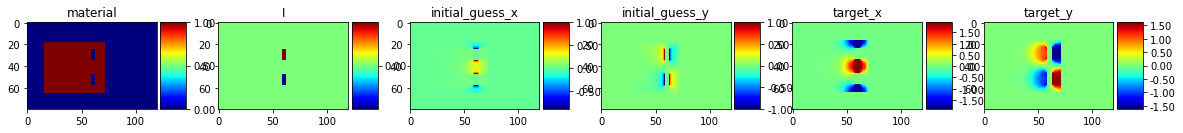

In [152]:
idx = 2
sample=val_set[idx]

fig, axes = plt.subplots(1,6,figsize=(20,4))

for i, name, image in zip(range(6),["material","I","initial_guess_x","initial_guess_y","target_x","target_y"], [sample[0][0,:,:],sample[0][1,:,:],sample[0][2,:,:],sample[0][3,:,:],sample[1][0,:,:],sample[1][1,:,:]]):
    im = axes[i].imshow(image.T, cmap='jet',interpolation='none')
    axes[i].set_title(name)

    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")
    

First takeaway: improve initial guess

Split up initial guess into x and y component

In [153]:
#Create model
model = UNet(in_channels=4,out_channels=2,depth=4)

In [154]:
# Select device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
else:
    device = 'cpu'

print(device)

mps


In [155]:
#Create Trainer

trainer_parameters = {
    "optimizer": optim.Adam,
    "optimizer_parameters": {
        "lr":5e-4
    },
    "loss_fun":nn.MSELoss,
    "device":torch.device(device),
    "model":model,
    "train_dataloader":train_loader,
    "val_dataloader":val_loader,
    "num_epochs": 500,
    "priority_mask_mode":"material"
}

trainer = Trainer(**trainer_parameters)

In [156]:
train_hist,val_hist = trainer.train()

	 Epoch 1:	 Train_loss: 0.0695	 Val_loss: 0.0827	12:23:20:26
	 Epoch 2:	 Train_loss: 0.0406	 Val_loss: 0.0309	12:23:36:26
	 Epoch 3:	 Train_loss: 0.0286	 Val_loss: 0.0203	12:23:51:2
	 Epoch 4:	 Train_loss: 0.0213	 Val_loss: 0.0185	13:0:4:41
	 Epoch 5:	 Train_loss: 0.0172	 Val_loss: 0.0133	13:0:18:44
	 Epoch 6:	 Train_loss: 0.0201	 Val_loss: 0.0153	13:0:33:17
	 Epoch 7:	 Train_loss: 0.0136	 Val_loss: 0.0122	13:0:47:0
	 Epoch 8:	 Train_loss: 0.0122	 Val_loss: 0.0112	13:1:0:4
	 Epoch 9:	 Train_loss: 0.0105	 Val_loss: 0.0097	13:1:13:27
	 Epoch 10:	 Train_loss: 0.0097	 Val_loss: 0.0093	13:1:26:56
	 Epoch 11:	 Train_loss: 0.0092	 Val_loss: 0.0087	13:1:40:56
	 Epoch 12:	 Train_loss: 0.0089	 Val_loss: 0.0084	13:1:54:44
	 Epoch 13:	 Train_loss: 0.0086	 Val_loss: 0.0083	13:2:8:9
	 Epoch 14:	 Train_loss: 0.0084	 Val_loss: 0.0081	13:2:21:44
	 Epoch 15:	 Train_loss: 0.0083	 Val_loss: 0.0079	13:2:35:25
	 Epoch 16:	 Train_loss: 0.0080	 Val_loss: 0.0078	13:2:48:56
	 Epoch 17:	 Train_loss: 0.0078	 Val_

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2941ff260>
    label = <none> 
    device = <AGXG13XDevice: 0x13a9e6600>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x15b0a0400>
        label = <none> 
        device = <AGXG13XDevice: 0x13a9e6600>
            name = Apple M1 Pro 
    retainedReferences = 1


	 Epoch 75:	 Train_loss: 0.0039	 Val_loss: 0.0042	13:16:8:16
	 Epoch 76:	 Train_loss: 0.0038	 Val_loss: 0.0043	13:16:26:7
	 Epoch 77:	 Train_loss: 0.0037	 Val_loss: 0.0039	13:16:41:16
	 Epoch 78:	 Train_loss: 0.0036	 Val_loss: 0.0039	13:16:54:37
	 Epoch 79:	 Train_loss: 0.0036	 Val_loss: 0.0039	13:17:8:40
	 Epoch 80:	 Train_loss: 0.0035	 Val_loss: 0.0038	13:17:24:12
	 Epoch 81:	 Train_loss: 0.0034	 Val_loss: 0.0035	13:17:39:0
	 Epoch 82:	 Train_loss: 0.0034	 Val_loss: 0.0038	13:17:54:7
	 Epoch 83:	 Train_loss: 0.0034	 Val_loss: 0.0039	13:18:8:27
	 Epoch 84:	 Train_loss: 0.0035	 Val_loss: 0.0044	13:18:23:38
	 Epoch 85:	 Train_loss: 0.0035	 Val_loss: 0.0035	13:18:38:26
	 Epoch 86:	 Train_loss: 0.0033	 Val_loss: 0.0034	13:18:53:10
	 Epoch 87:	 Train_loss: 0.0031	 Val_loss: 0.0035	13:19:7:21
	 Epoch 88:	 Train_loss: 0.0031	 Val_loss: 0.0036	13:19:20:48
	 Epoch 89:	 Train_loss: 0.0030	 Val_loss: 0.0035	13:19:34:14
	 Epoch 90:	 Train_loss: 0.0029	 Val_loss: 0.0033	13:19:47:15
	 Epoch 91:	 Tr

ValueError: x and y must have same first dimension, but have shapes (500,) and (242,)

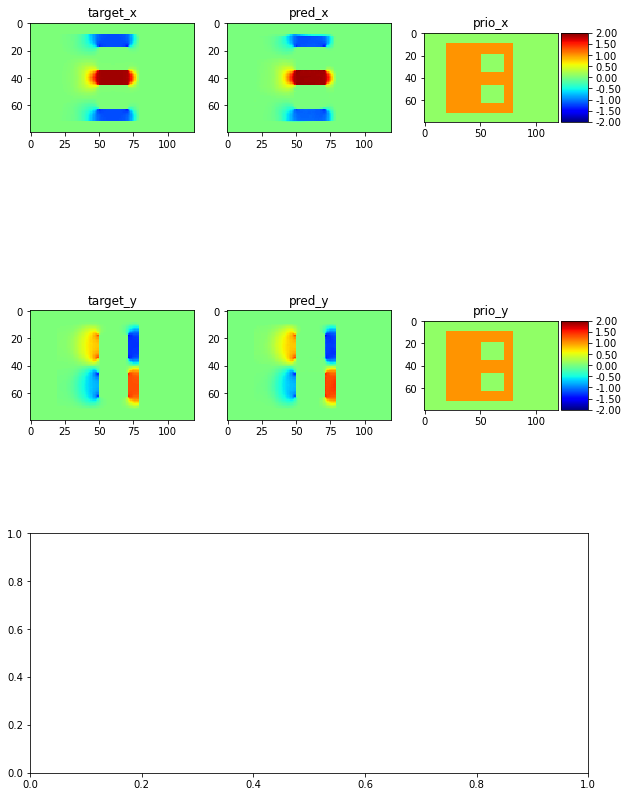

In [158]:
# model = UNet(in_channels=4,out_channels=2,depth=4)
model.load_state_dict(torch.load("last_checkpoint.pth"))
model.eval()

idx = 120
x,y=train_set[idx]

#x[1,:,:] = np.zeros_like(sample[0][1,:,:])

fig, axes = plt.subplots(3,3,figsize=(10,15))

gs = axes[2, 0].get_gridspec()
axes[2,0].remove()
axes[2,1].remove()
axes[2,2].remove()
axbig = fig.add_subplot(gs[2, 0:])

im0 = axes[0][0].imshow(y[0,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[0][0].set_title("target_x")
im1 = axes[1][0].imshow(y[1,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[1][0].set_title("target_y")

model.to('cpu')
prediction = model(torch.tensor(x).unsqueeze(0).float()).squeeze().detach().numpy() 

im2 = axes[0][1].imshow(prediction[0,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[0][1].set_title("pred_x")
im3 = axes[1][1].imshow(prediction[1,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[1][1].set_title("pred_y")

material_stack = torch.stack([torch.tensor(x)[0,:,:],torch.tensor(x)[0,:,:]],0)
priority_mask = torch.max(torch.ones_like(torch.tensor(y))*0.1,material_stack)


im2 = axes[0][2].imshow(priority_mask[0,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[0][2].set_title("prio_x")
im3 = axes[1][2].imshow(priority_mask[1,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[1][2].set_title("prio_y")

divider = make_axes_locatable(axes[0][2])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")

divider = make_axes_locatable(axes[1][2])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar = plt.colorbar(im3, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")


x = np.linspace(0, trainer_parameters["num_epochs"], trainer_parameters["num_epochs"])
axbig.plot(x, train_hist)
axbig.plot(x, val_hist)


